In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics

In [ ]:
location = pd.read_csv('/content/drive/MyDrive/HTML final project/location.csv')
population = pd.read_csv('/content/drive/MyDrive/HTML final project/population.csv')

In [ ]:
# merge location.csv and population.csv
location['Population'] = location['Zip Code'].map(population.set_index('Zip Code')['Population'])

# fill in NaN because all values are same
location.fillna(value = {"Count": 1.0, "Country": 'United States', "State": 'California'}, inplace = True)
location['Country'].replace(['United States'], [0.0],inplace = True)
location['State'].replace(['California'], [0.0],inplace = True)

# ['Acampo', 'Acton', 'Adelanto', ...... , 'Yucca Valley', 'Zenia'] to [0, 1, 2, ......, 1100]
location['City'].replace(sorted(location['City'].loc[~location['City'].isnull()].unique()),
                         list(range(len(location['City'].loc[~location['City'].isnull()].unique()))), inplace = True)

# fill in 'Latitude', 'Longitude' Nan by 'Lat Long'
location['Latitude'].fillna(pd.to_numeric(location['Lat Long'].str.split(',').str[0]), inplace=True)
location['Longitude'].fillna(pd.to_numeric(location['Lat Long'].str.split(',').str[1]), inplace=True)
location.drop(['Lat Long'], axis=1, inplace=True)

# fill in all Nan in columns about region

In [ ]:
print(location.isna().sum())

# fill in City, Latitude, Longitude, Population by zip code
filled_in_column_lst = ['City', 'Latitude', 'Longitude', 'Population']
for filled_col in filled_in_column_lst:
  col_i_unique_val = location['Zip Code'].unique()
  col_i_unique_val = col_i_unique_val[~np.isnan(col_i_unique_val)]
  for i_val in col_i_unique_val:
    if location.loc[location['Zip Code'] == i_val].loc[location[filled_col].notnull()].size != 0:
      location.loc[location['Zip Code'] == i_val, filled_col] = location.loc[location['Zip Code'] == i_val].loc[location[filled_col].notnull()].iloc[0][filled_col]

print(location.isna().sum())

Customer ID      0
Count            0
Country          0
State            0
City           770
Zip Code       770
Latitude        93
Longitude       86
Population     770
dtype: int64
Customer ID      0
Count            0
Country          0
State            0
City           131
Zip Code       770
Latitude         9
Longitude        8
Population     770
dtype: int64


In [ ]:
location.to_csv('/content/drive/MyDrive/HTML final project/location_with_population_and_fill_in_nan.csv', index=False)
location

,Customer ID,Count,Country,State,City,Zip Code,Latitude,Longitude,Population
0,1746-TGTWV,1.0,0.0,0.0,550.0,90022.0,34.023810,-118.156582,68701.0
1,2041-JIJCI,1.0,0.0,0.0,550.0,NaN,34.108833,-118.229715,NaN
2,5832-EXGTT,1.0,0.0,0.0,445.0,90303.0,33.936291,-118.332639,27778.0
3,8350-NYMVI,1.0,0.0,0.0,1067.0,90602.0,33.972119,-118.020188,26265.0
4,3458-IDMFK,1.0,0.0,0.0,548.0,90720.0,33.794990,-118.065591,21343.0
...,...,...,...,...,...,...,...,...,...
6158,7609-NRNCA,1.0,0.0,0.0,511.0,92285.0,34.341737,-116.539416,2182.0
6159,4835-YSJMR,1.0,0.0,0.0,2.0,92301.0,34.667815,-117.536183,18980.0
6160,5067-DGXLL,1.0,0.0,0.0,22.0,92304.0,34.559882,-115.637164,42.0
6161,3129-AAQOU,1.0,0.0,0.0,26.0,92305.0,34.167800,-116.864330,301.0


# 嘗試只用 location.csv 預測答案（可以不用管這裡）

In [ ]:
satisfaction = pd.read_csv('/content/drive/MyDrive/HTML final project/satisfaction.csv')
status = pd.read_csv('/content/drive/MyDrive/HTML final project/status.csv')
Train_IDs = pd.read_csv('/content/drive/MyDrive/HTML final project/Train_IDs.csv')

# change string to value
status['Churn Category'].replace(['No Churn', 'Competitor', 'Dissatisfaction', 'Attitude', 'Price', 'Other'], [0, 1, 2, 3, 4, 5], inplace = True)
location.drop(['Population'], axis=1, inplace=True)
# data = pd.merge(pd.merge(satisfaction, location, on="Customer ID"), status, on="Customer ID")
data = pd.merge(status, location, on="Customer ID")
training_data = pd.merge(data, Train_IDs, on=["Customer ID"])

KeyError: ignored

In [ ]:
training_data = training_data[training_data['Churn Category'] != 0] # Satisfaction Score < 3
print(training_data['Churn Category'].value_counts())
print(training_data.isna().sum())
# training_data
training_data.dropna(inplace=True)
x_train = training_data.iloc[:, 2:]

print(x_train.columns)
# x_train = x_train.fillna(x_train.median())
x_train = x_train.to_numpy()

y_train = training_data['Churn Category'].to_numpy()

print("x_train.shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)

y_train = y_train.astype('int')
y_train = np.where(y_train == 1, 1, -1)

1    364
3    159
2    128
4     95
5     91
Name: Churn Category, dtype: int64
Customer ID       0
Churn Category    0
Count             0
Country           0
State             0
City              0
Zip Code          0
Latitude          0
Longitude         0
dtype: int64
Index(['Count', 'Country', 'State', 'City', 'Zip Code', 'Latitude',
       'Longitude'],
      dtype='object')
x_train.shape:  (837, 7)
y_train.shape:  (837,)


[0.         0.         0.         0.2178871  0.22729663 0.30491836
 0.24989791]
0.625


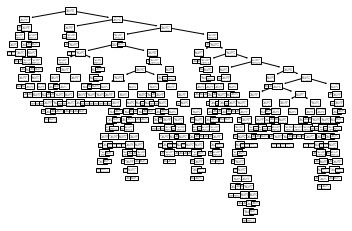

In [ ]:
from sklearn.model_selection import train_test_split
x_val_train, x_val_test, y_val_train, y_val_test = train_test_split(x_train, y_train, test_size=0.2)

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
DT = DecisionTreeClassifier()
val_clf = DT.fit(x_val_train, y_val_train)

print(val_clf.feature_importances_)
tree.plot_tree(val_clf)
val_y_predicted = val_clf.predict(x_val_test)
val_acc = metrics.accuracy_score(y_val_test, val_y_predicted)
print(val_acc)


# Random forest

In [ ]:
from sklearn.model_selection import train_test_split
x_val_train, x_val_test, y_val_train, y_val_test = train_test_split(x_train, y_train, test_size=0.2)

# !pip install catboost
# from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# CAT = CatBoostClassifier
MLP = MLPClassifier()
NB = GaussianNB()
QDA = QuadraticDiscriminantAnalysis()
SVCCC = SVC()
LR = LogisticRegression()
KNN = KNeighborsClassifier()
SGD = SGDClassifier()
ADA = AdaBoostClassifier()
DT = DecisionTreeClassifier()
RF = BaggingClassifier(DT)
XGB = XGBClassifier()
LGBM = LGBMClassifier()
GDB = GradientBoostingClassifier()

clf_lst = [MLP, NB, QDA, SVCCC, LR, KNN, SGD, ADA, DT, RF, XGB, LGBM, GDB]
clf_lst_name = ['MLP', 'NB', 'QDA', 'SVCCC', 'LR', 'KNN', 'SGD', 'ADA', 'DT', 'RF', 'XGB', 'LGBM', 'GDB']
# clf_lst = [ADA, DT, XGB, LGBM, GDB]
val_acc_lst = []

from sklearn.metrics import f1_score
for clf in clf_lst:
  val_clf = clf.fit(x_val_train, y_val_train)
  # print(f'{clf}: ', clf.feature_importances_)
  val_y_predicted = val_clf.predict(x_val_test)
  val_acc = metrics.f1_score(y_val_test, val_y_predicted, average='macro')
  val_acc_lst.append(val_acc)
  print(f'{clf} false: ')
  print(y_val_test[(y_val_test != val_y_predicted)])
  print(val_y_predicted[(y_val_test != val_y_predicted)])
  print(f'{clf} true: ')
  print(y_val_test[(y_val_test == val_y_predicted)])
  print()

print()
print("acc:")
for i in range(len(clf_lst)):
  print(f'{clf_lst_name[i]:}: {val_acc_lst[i]}')

MLPClassifier() false: 
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MLPClassifier() true: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

GaussianNB() false: 
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:903: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:903: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:906: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


AdaBoostClassifier() false: 
[ 1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1 -1
 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1  1 -1 -1  1  1 -1  1
 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1]
[-1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1
  1  1 -1 -1  1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1
  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
AdaBoostClassifier() true: 
[-1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1
  1 -1  1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1  1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1
  1 -1  1 -1 -1 -1  1 -1]

DecisionTreeClassifier() false: 
[ 1 -1 -1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1
 -1 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1  1 -1  1  1 -1
 -1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1  1 -1]
[-1

In [ ]:
300/1409

0.21291696238466998